In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 181 kB 46.5 MB/s 
     |████████████████████████████████| 144 kB 48.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=75249c1f9fee58fb121b38c7b3ddeab92991fc42b7951914fd2c1c18dbb62960
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization

#importing ImageDataGenarator for data augmentation 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import cv2
import wandb
import matplotlib.image as mpimg

In [ ]:
#importing the dataset to be worked on = inaturalist dataset

%%capture
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip
!unzip nature_12K.zip

train_dir='inaturalist_12K/train/'  #specifying the train and test data as per available in the dataset.
test_dir='inaturalist_12K/val/'

#specifying the classes as present in the iNaturalist dataset
 
categories=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

#so as we can see there are 10 classes in the inaturalist dataset.

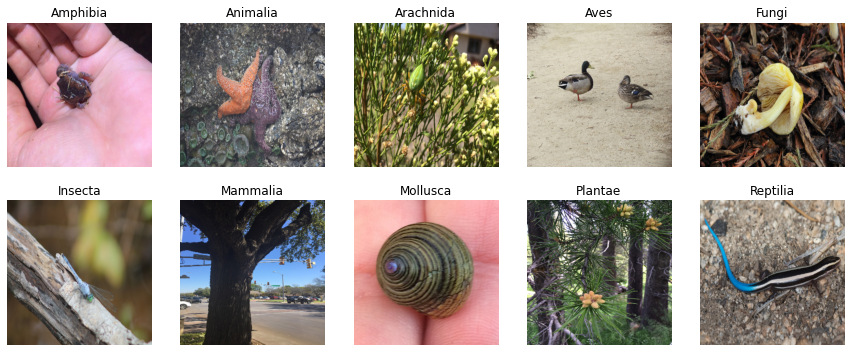

In [ ]:
#visualizing images 
fig = plt.figure(figsize=(15,6))
rows,columns=2,5
i=1
for clas in categories:
  dir=os.path.join(train_dir,clas)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    fig.add_subplot(rows,columns,i)
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(clas)
    i+=1   
    break
  

In [ ]:
# sweep. 
#run this cell when using wandb for sweep

sweep_config = {
  'name': 'Bayesian',  
  'method': 'bayes',
  "metric":{
  "name": "val_accuracy",
  "goal": "maximize"
  },
  'parameters': {
        
        'filters': {
            'values': ['inc_dec','dec_inc']
        },
        'fc_size':{
            'values':[128,256]
        },
        'batchnorm':{
            'values':['yes']
        },
        'augmentation':{
            'values':['yes']   
        },
        'droprate':{
            'values':[0.4,0.5]
        },
        'epoch':{
            'values':[5,10,3]
        }
           
    }

}

#this configuration gives the best validation accuracy
config_defaults={
    'filters':'inc',
    'fc_size':256,
    'batchnorm':'yes',
    'augmentation':'no',
    'droprate':0.3
}

In [ ]:
#defining function for training

def Train_CNN():
  #initializing the wandb sweeps for combinations
  #uncomment it when to enable sweeps

  wandb.init(config=config_defaults)
  configs=wandb.config
  #initializing the sweeps with defaults set
  configs=config_defaults

  batchnorm=configs['batchnorm']
  droprate=configs['droprate']
  augmentation=configs['augmentation']
  filter_=configs['filters']
  fc_size=configs['fc_size']

  wandb.run.name='filters_'+filter_+'_fc_size_'+str(fc_size)+'_droprate_'+str(droprate)+ str('_bn_' if batchnorm=='yes' else '') +str('augment' if augmentation=='yes' else '')

#defining the image dimensions
  img_height,img_width=300,300

#defining the filters
  if filter_=='inc' :
    filters=[16,32,64,128,256]
  elif filter_ =='inc_dec':
    filters=[32,64,128,64,32]
  elif filter_ == 'dec' :
    filters=[128,64,32,16,8]
  elif filter_ =='dec_inc' :
    filters=[128,64,32,64,128]  
  elif filter_=='all_32' :
    filters=[32,32,32,32,32]
  elif filter_ == 'all_64':
    filters=[64,64,64,64,64]


  model=models.Sequential()

#adding layers = 5 conv layers with 1 output layer with 10 neurons

#input layer=1st layer
  model.add(Conv2D(filters[0], (3, 3),input_shape=(img_height,img_width,3),activation='relu'))    
  if batchnorm =='yes':
    model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

#2nd layer
  model.add(Conv2D(filters[1], (3, 3),activation='relu'))
  model.add(MaxPooling2D((2, 2)))

#3rd layer
  model.add(Conv2D(filters[2], (3, 3),activation='relu'))
  model.add(MaxPooling2D((2, 2)))

#4th layer
  model.add(Conv2D(filters[3], (3, 3),activation='relu'))
  model.add(MaxPooling2D((2, 2)))

#5th layer
  model.add(Conv2D(filters[4], (3, 3),activation='relu'))
  if batchnorm =='yes':
    model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))


  model.add(Flatten())
  model.add(Dense(fc_size,activation='relu')) 
  if batchnorm =='yes':
    model.add(BatchNormalization())
  model.add(Dropout(droprate))
#output layer with activation function as softmax
  model.add(Dense(10,activation='softmax'))

  #data generators for train(with and without augmentation) and validation set
  augment= ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0 / 255,
    validation_split=0.1,
  )

  datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.1,
  )

  train_set = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    subset='training',
    seed=123,
  )

  aug_set = augment.flow_from_directory(
      train_dir,
      target_size=(img_height, img_width),
      batch_size=32,
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      subset='training',
      seed=123,
  )

  val_set = datagen.flow_from_directory(
      train_dir,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      subset='validation',
      seed=123,
  )
#compiling the whole model with parameters and associating the losses in the model as cross entropy 
  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
    metrics=['accuracy'],
  )

  #making the model flexible for augmentation
  # giving the callback for data plot as wandb
  if augmentation =='no' :
    hist=model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
    hist=model.fit(train_set,epochs=10,validation_data=val_set)

  else:
    hist=model.fit(aug_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
    hist=model.fit(aug_set,epochs=10,validation_data=val_set)
  #defining the validation accuracy  
  val_acc=max(hist.history['val_accuracy'])
  params={'batch_norm':batchnorm,'augmentation':augmentation,'dropout':droprate,'filter_architecture':filter_,'val_acc':val_acc}
  wandb.log(params)

In [ ]:
#wandb sweep initialization
#Ignore this 
sweep_id=wandb.sweep(sweep_config,project="part-a", entity="dl22")
wandb.agent(sweep_id, Train_CNN)         

Create sweep with ID: hlhlejqo
Sweep URL: https://wandb.ai/dl22/part-a/sweeps/hlhlejqo


wandb: Agent Starting Run: 5pxuy1wv with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	epoch: 10
wandb: 	fc_size: 128
wandb: 	filters: inc_dec
wandb: Currently logged in as: dl22 (use `wandb login --relogin` to force relogin)


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 175s 580ms/step - loss: 2.3787 - accuracy: 0.2208 - val_loss: 3.1799 - val_accuracy: 0.1141 - _timestamp: 1649099779.0000 - _runtime: 192.0000
Epoch 2/10
282/282 [==============================] - 151s 535ms/step - loss: 2.1605 - accuracy: 0.2643 - val_loss: 2.1608 - val_accuracy: 0.2402 - _timestamp: 1649099930.0000 - _runtime: 343.0000
Epoch 3/10
282/282 [==============================] - 148s 525ms/step - loss: 2.0260 - accuracy: 0.3004 - val_loss: 2.2244 - val_accuracy: 0.2312 - _timestamp: 1649100079.0000 - _runtime: 492.0000
Epoch 4/10
282/282 [==============================] - 149s 527ms/step - loss: 1.9406 - accuracy: 0.3250 - val_loss: 2.0818 - val_accuracy: 0.3123 - _timestamp: 1649100227.0000 - _runtime: 640.0000
Epoch 5/10
282/282 [==============================] - 148s 525ms/step - loss: 1.8628

accuracy,▁▂▃▃▄▄▅▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▄▃▃▂▁
val_acc,▁
val_accuracy,▁▄▄▆▆▅█▇▇█
val_loss,█▂▃▂▃▃▁▁▁▂
accuracy,0.53244
augmentation,no
batch_norm,yes
best_epoch,7


wandb: Agent Starting Run: tst9q5k7 with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.5
wandb: 	epoch: 5
wandb: 	fc_size: 128
wandb: 	filters: dec_inc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 150s 530ms/step - loss: 2.3806 - accuracy: 0.2177 - val_loss: 2.6405 - val_accuracy: 0.1351 - _timestamp: 1649102826.0000 - _runtime: 161.0000
Epoch 2/10
282/282 [==============================] - 148s 526ms/step - loss: 2.1527 - accuracy: 0.2699 - val_loss: 2.0521 - val_accuracy: 0.2943 - _timestamp: 1649102975.0000 - _runtime: 310.0000
Epoch 3/10
282/282 [==============================] - 148s 523ms/step - loss: 2.0000 - accuracy: 0.3106 - val_loss: 2.0914 - val_accuracy: 0.2813 - _timestamp: 1649103122.0000 - _runtime: 457.0000
Epoch 4/10
282/282 [==============================] - 147s 521ms/step - loss: 1.8977 - accuracy: 0.3404 - val_loss: 2.1398 - val_accuracy: 0.2933 - _timestamp: 1649103269.0000 - _runtime: 604.0000
Epoch 5/10
282/282 [==============================] - 143s 506ms/step - loss: 1.7911

accuracy,▁▂▃▃▄▄▅▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▄▄▃▂▁
val_acc,▁
val_accuracy,▁▆▆▆▆▆▇█▇█
val_loss,█▂▂▃▄▂▁▃▆▂
accuracy,0.62289
augmentation,no
batch_norm,yes
best_epoch,6


wandb: Agent Starting Run: uzb6zqrl with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.5
wandb: 	epoch: 3
wandb: 	fc_size: 128
wandb: 	filters: inc_dec


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 149s 526ms/step - loss: 2.3730 - accuracy: 0.2220 - val_loss: 2.8805 - val_accuracy: 0.1141 - _timestamp: 1649105826.0000 - _runtime: 160.0000
Epoch 2/10
282/282 [==============================] - 146s 518ms/step - loss: 2.1287 - accuracy: 0.2683 - val_loss: 2.3006 - val_accuracy: 0.2312 - _timestamp: 1649105972.0000 - _runtime: 306.0000
Epoch 3/10
282/282 [==============================] - 144s 512ms/step - loss: 2.0239 - accuracy: 0.3010 - val_loss: 2.3738 - val_accuracy: 0.2442 - _timestamp: 1649106117.0000 - _runtime: 451.0000
Epoch 4/10
282/282 [==============================] - 146s 517ms/step - loss: 1.8986 - accuracy: 0.3320 - val_loss: 1.9199 - val_accuracy: 0.3223 - _timestamp: 1649106263.0000 - _runtime: 597.0000
Epoch 5/10
282/282 [==============================] - 146s 516ms/step - loss: 1.8021

accuracy,▁▂▃▃▄▄▅▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▄▃▃▂▁
val_acc,▁
val_accuracy,▁▅▅███████
val_loss,█▄▄▁▂▂▁▃▂▂
accuracy,0.58478
augmentation,no
batch_norm,yes
best_epoch,3


wandb: Agent Starting Run: he4839ob with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.5
wandb: 	epoch: 5
wandb: 	fc_size: 256
wandb: 	filters: inc_dec


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 150s 527ms/step - loss: 2.3995 - accuracy: 0.2084 - val_loss: 2.7351 - val_accuracy: 0.1401 - _timestamp: 1649108883.0000 - _runtime: 160.0000
Epoch 2/10
 88/282 [========>.....................] - ETA: 1:31 - loss: 2.2040 - accuracy: 0.2507

In [ ]:
#Trial run with config defaults
Train_CNN()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 167s 548ms/step - loss: 2.4067 - accuracy: 0.2186 - val_loss: 3.2052 - val_accuracy: 0.1101 - _timestamp: 1649499156.0000 - _runtime: 182.0000
Epoch 2/10
282/282 [==============================] - 142s 504ms/step - loss: 2.1709 - accuracy: 0.2594 - val_loss: 2.0941 - val_accuracy: 0.2823 - _timestamp: 1649499298.0000 - _runtime: 324.0000
Epoch 3/10
282/282 [==============================] - 146s 518ms/step - loss: 2.0267 - accuracy: 0.3011 - val_loss: 2.2968 - val_accuracy: 0.2633 - _timestamp: 1649499445.0000 - _runtime: 471.0000
Epoch 4/10
282/282 [==============================] - 144s 509ms/step - loss: 1.9275 - accuracy: 0.3292 - val_loss: 2.0747 - val_accuracy: 0.3143 - _timestamp: 1649499588.0000 - _runtime: 614.0000
Epoch 5/10
282/282 [==============================] - 144s 511ms/step - loss: 1.8340

In [ ]:
#train model with best configs
model=models.Sequential()

#defining the image input
img_height,img_width=300,300

#adding layers= 5 layers with filters and relu as activation function
#1st layer= input layer
#adding a maxpooling 
#maxpooling when added to a model in individual layers, reduces the dimensionality of images by reducing the number of pixels in the output from the previous convolutional layer. 
model.add(Conv2D(16,(3, 3),input_shape=(img_height,img_width,3),activation='relu'))    
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

#2nd layer with relu activation and maxpooling
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

#3rd layer with relu activation and maxpooling
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

#4th layer with relu activation and maxpooling
model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

#5th layer with relu activation and maxpooling
model.add(Conv2D(256, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

#output layer with 10neurons and softmax activation function
model.add(Dense(10,activation='softmax'))

#taking the summary of how the model looks
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 batch_normalization_3 (Batc  (None, 298, 298, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                      

In [ ]:
#data generators for train and validation set
augment= ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0 / 255,
    validation_split=0.1
)

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.1
)

train_set = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    subset='training',
    seed=123,
)

aug_set = augment.flow_from_directory(
      train_dir,
      target_size=(img_height, img_width),
      batch_size=32,
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      subset='training',
      seed=123,
)

val_set = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    subset='validation',
    seed=123,
)


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


In [ ]:
#compiling the whole model with parameters and associating the losses in the model as cross entropy
 
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
    metrics=['accuracy'],
  )

#adding early stop to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True)

#fitting the model on training set
model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[early_stop])

Epoch 1/10
282/282 [==============================] - 142s 501ms/step - loss: 2.3791 - accuracy: 0.2207 - val_loss: 2.5998 - val_accuracy: 0.1251
Epoch 2/10
282/282 [==============================] - 143s 508ms/step - loss: 2.1720 - accuracy: 0.2689 - val_loss: 2.2667 - val_accuracy: 0.2302
Epoch 3/10
282/282 [==============================] - 143s 506ms/step - loss: 2.0181 - accuracy: 0.2991 - val_loss: 2.3995 - val_accuracy: 0.2372
Epoch 4/10
282/282 [==============================] - 144s 511ms/step - loss: 1.9079 - accuracy: 0.3342 - val_loss: 2.0316 - val_accuracy: 0.3103
Epoch 5/10
282/282 [==============================] - 145s 514ms/step - loss: 1.8261 - accuracy: 0.3568 - val_loss: 1.9612 - val_accuracy: 0.3383
Epoch 6/10
282/282 [==============================] - 146s 517ms/step - loss: 1.7502 - accuracy: 0.3888 - val_loss: 2.0545 - val_accuracy: 0.3293
Epoch 7/10
282/282 [==============================] - 145s 513ms/step - loss: 1.6570 - accuracy: 0.4161 - val_loss: 1.9774 -

In [ ]:
#data generator for test set
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
  )

test_set = test_datagen.flow_from_directory(
      test_dir,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      seed=123,
  )

#evaluating model on test set
model.evaluate(test_set)

Found 2000 images belonging to 10 classes.
63/63 [==============================] - 28s 449ms/step - loss: 2.0346 - accuracy: 0.3490


[2.0346179008483887, 0.3490000069141388]

wandb: Currently logged in as: dl22 (use `wandb login --relogin` to force relogin)


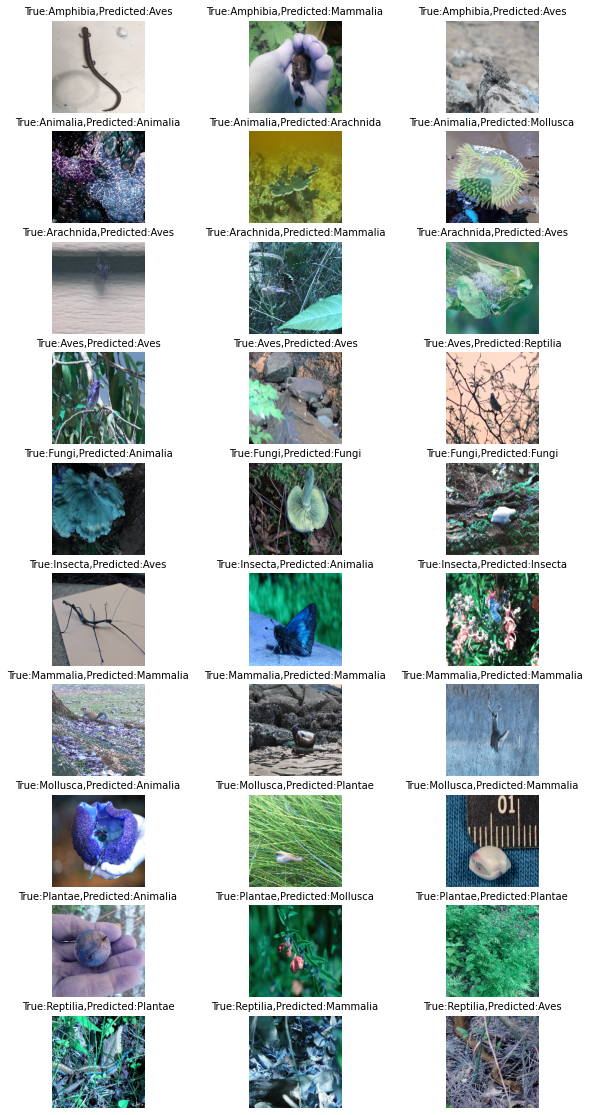

In [ ]:
#taking 30 sample images,3 from each class for visualizing

x,y,y_pred=[],[],[]
for clas in categories:
    i=0
    path=os.path.join(test_dir,clas)
    for img in os.listdir(path):
      if i==3:
        break
      try:
        image = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
        x.append(image)
        y.append(clas)
        pic = cv2.resize(image, (300,300)) / 255.0
        prediction = model.predict(pic.reshape(1,300, 300,3))
        c=prediction.argmax()
        y_pred.append(categories[c])
        i+=1
      except:
        break

#plotting a 10x3 grid with predictions
fig = plt.figure(figsize=(10,20))
rows,columns=10,3
i=1
for k in range(30):

  img=cv2.resize(x[k],(150,150))
  fig.add_subplot(rows,columns,i)
  plt.imshow(img)
  plt.axis('off')
  plt.title('True:'+y[k]+',Predicted:'+y_pred[k],fontdict={'fontsize':10})
  i+=1   
wandb.init(project="part-a", entity="dl22")
wandb.log({'predicting on sample images':plt}) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


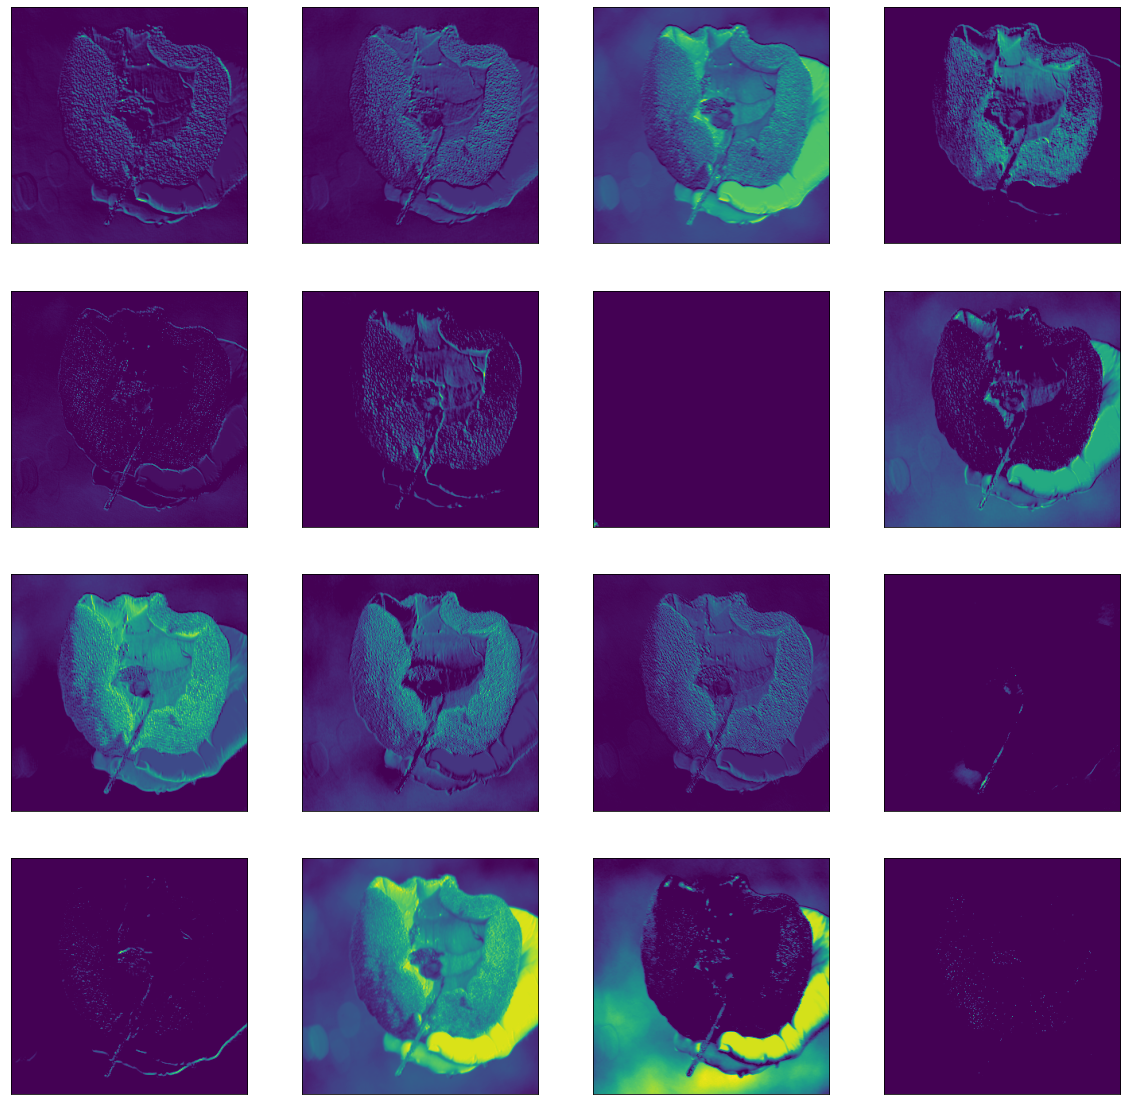

In [18]:
#visualizing filters

def fil_vis(lay='conv2d_5'):              #name of 1st conv layer
  fil_model = tf.keras.models.Model(
      inputs = [model.inputs],    
      outputs = [model.get_layer(lay).output]
  )
  category = categories[7]
  dir=os.path.join(test_dir,category)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=cv2.imread(img_path)
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    x = np.expand_dims(new_img, axis=0) 
    inputs = tf.cast(x, tf.float32)
    out = fil_model(inputs)[0]

      
  
    #f_min, f_max = out.min(), out.max()
    #filters = (out - f_min) / (f_max - f_min)
    # plot first few filters
    n_filters, ix = 16, 1
    plt.figure(figsize=(20,20))
    for i in range(n_filters):
      # get the filter
      f = out[:, :, i]
      # plot each channel separately
      for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(4, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f)
      ix += 1
    # view the figure
    plt.show()
    break

fil_vis()

In [ ]:
name_layer = 'conv5'

@tf.custom_gradient
def guided_Relu(x):
  def grad_1(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad_1



def back_prop(model, layer=name_layer, N_new=10, cat = 0,fil = 2):
  gb_model = tf.keras.models.Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer(name_layer).output])
  layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

  for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
      layer.activation = guided_Relu
  category = categories[cat]
  dir=os.path.join(train_dir,category)
  fig = plt.figure(figsize=(30,20))
  for img in os.listdir(dir):
    columns=5
    rows = 2
    
    img_path=(os.path.join(dir,img))
    imgs=cv2.imread(img_path)
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    x = np.expand_dims(new_img, axis=0)
    j=1
    i=0
    while j <= N_new:
      with tf.GradientTape() as tape:
        inputs = tf.cast(x, tf.float32)
        tape.watch(inputs)
        outputs = gb_model(inputs)[0]
        
      
        
        if outputs[i,i,fil] != 0:
          out = outputs[i,i,fil]
          grads = tape.gradient(out,inputs)[0]
          guided_back_prop =grads
          gb_viz = np.dstack((
                      guided_back_prop[:, :, 0],
                      guided_back_prop[:, :, 1],
                      guided_back_prop[:, :, 2],
                  ))       
          gb_viz -= np.min(gb_viz)
          gb_viz /= gb_viz.max()
          fig.add_subplot(rows,columns,j)
          plt.imshow(gb_viz)
          plt.title(category)
          j+=1
          i+=1
        else:
          i+=1  
    break

In [ ]:
back_prop(model)